In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import sys, os
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')

!pip install -qU catboost spacy
from catboost import CatBoostClassifier, Pool
import spacy
clear_output()
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert - useful tutorial about using BERT models in txt cls

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
email_root = '/content/drive/My Drive/data/email_spam/email.csv'

In [4]:
df = pd.read_csv(email_root)

In [5]:
df.head(3)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1


In [6]:
stop = stopwords.words('english')

In [7]:
def cross_validation(clf, X, y, scoring='f1', cv=5):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}') 
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

In [8]:
def preprocessor(text, is_soup=False):
    if is_soup:
        soup = bs(text, 'html.parser').getText()
    text = re.sub('Subject: ', '', text)
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text = re.sub(r'[^\w]', ' ', text)
    text = [w for w in text.split() if w not in stop]
    text = [re.sub(r"[^a-zA-Z0-9]+", '', k) for k in text]
    return re.sub(' +', ' ', ' '.join(text))

In [9]:
def get_X_batch(data):
    for i in range(data.shape[0]):
        text = preprocessor(data.iloc[i, 0])
        label = data.iloc[i, 1]
        yield text, label

In [10]:
df.text = df.text.apply(lambda x: preprocessor(x))

In [11]:
def simple_porter(text):
    p_stemmer = PorterStemmer()
    new_text = ''
    for word in text.split():
        new_text += p_stemmer.stem(word) + ' '
    return new_text

def snow_stem(text):
    snow_stemmer = SnowballStemmer(language='english')
    new_text = ''
    for word in text.split():
        new_text += snow_stemmer.stem(word) + ' '
    return new_text

def lemmatize(text):
    new_text = ''
    for token in nlp(text):
        new_text += token.lemma_ + ' '
    return new_text

In [ ]:
df['p_stemmer'] = df.text.apply(lambda x: simple_porter(x))
df['snow_stemmer'] = df.text.apply(lambda x: snow_stem(x))

In [12]:
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
clear_output()

In [13]:
df['lemmas'] = df.text.apply(lambda x: lemmatize(x))

In [14]:
X, y = df.lemmas, df.spam

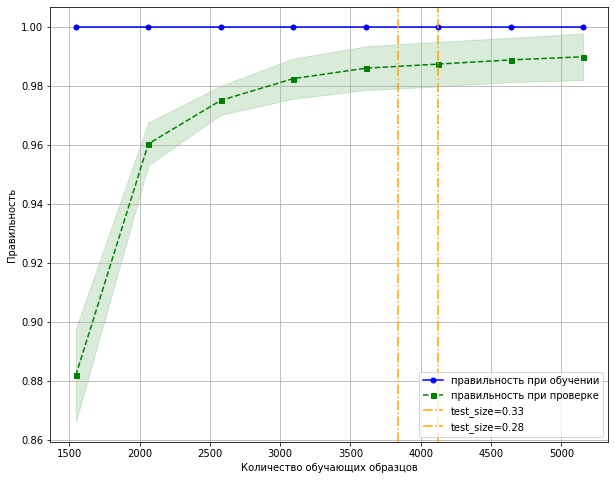

In [ ]:
X_ = TfidfVectorizer(lowercase=False).fit_transform(X)
estimator = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced')
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X_, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='f1', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.72, color='orange', linestyle='-.', label='test_size=0.28')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# оптимальный test_size=0.28

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=1)

In [16]:
"""
Convert a collection of raw documents to a matrix of TF-IDF features.
Equivalent to CountVectorizer followed by TfidfTransformer.
Also try HashingVectorizer
"""
#tfid_raw = TfidfVectorizer(lowercase=False)
#X_raw = tfid_raw.fit_transform(df.text)
#tfid_stem = TfidfVectorizer(lowercase=False)
#X_stem = tfid_stem.fit_transform(df.p_stemmer)
#tfid_snow = TfidfVectorizer(lowercase=False)
#X_snow = tfid_snow.fit_transform(df.snow_stemmer)
tfid_lemma = TfidfVectorizer(lowercase=False)
X_train = tfid_lemma.fit_transform(X_train)
X_test = tfid_lemma.transform(X_test)

In [19]:
base = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-3,
                          max_iter=200, class_weight='balanced').fit(X_train, y_train)
# may use SGDClassifier to further learn on test data after evaluating metrics, this will improve accuracy

In [20]:
y_train_pred = base.predict(X_train)
y_test_pred = base.predict(X_test)
y_train_proba = base.predict_proba(X_train)[:,1]
y_test_proba = base.predict_proba(X_test)[:,1]

In [21]:
report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba, y_test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      3270
           1      1.000     1.000     1.000      1026

    accuracy                          1.000      4296
   macro avg      1.000     1.000     1.000      4296
weighted avg      1.000     1.000     1.000      4296

Test
               precision    recall  f1-score   support

           0      0.998     0.996     0.997      1090
           1      0.988     0.994     0.991       342

    accuracy                          0.996      1432
   macro avg      0.993     0.995     0.994      1432
weighted avg      0.996     0.996     0.996      1432

Train ROC_AUC: 1.000, Test ROC_AUC: 1.000
Confusion Matrix 
 col_0     0    1
spam            
0      1086    4
1         2  340


In [23]:
cross_validation(base, X_train, y_train, scoring='f1', cv=5)

Меры правильности перекрекстной оценки: [0.98296837 0.97788698 0.98550725 0.98280098 0.98288509]
Точность перекретсной оценки: 0.982 +/- 0.002


array([0.98296837, 0.97788698, 0.98550725, 0.98280098, 0.98288509])

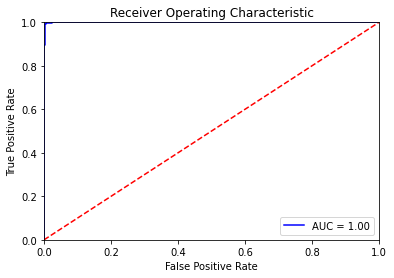

In [ ]:
from sklearn import metrics
probs = base.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
params_model = {
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'early_stopping_rounds': 10,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'random_seed': 1
}

In [ ]:
catboost = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=20, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

In [ ]:
gs['params']

{'bagging_temperature': 1.5,
 'depth': 4,
 'iterations': 400,
 'l2_leaf_reg': 2.5,
 'learning_rate': 0.3,
 'subsample': 0.3}

In [ ]:
catboost = CatBoostClassifier(**params_model, depth=4, iterations=800, learning_rate=0.3, l2_leaf_reg=2.5,
                              bagging_temperature=1.5, subsample=0.3, colsample_bylevel=0.7)
catboost.fit(train_pool, eval_set=test_pool)
cat_train_pred = catboost.predict(X_train)
cat_test_pred = catboost.predict(X_test)
cat_train_proba = catboost.predict_proba(X_train)[:,1]
cat_test_proba = catboost.predict_proba(X_test)[:,1]

In [ ]:
report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     0.991     0.996      3270
           1      0.973     1.000     0.987      1026

    accuracy                          0.993      4296
   macro avg      0.987     0.996     0.991      4296
weighted avg      0.994     0.993     0.994      4296

Test
               precision    recall  f1-score   support

           0      0.999     0.975     0.987      1090
           1      0.927     0.997     0.961       342

    accuracy                          0.980      1432
   macro avg      0.963     0.986     0.974      1432
weighted avg      0.982     0.980     0.981      1432

Train ROC_AUC: 1.000, Test ROC_AUC: 0.999
Confusion Matrix 
 col_0     0    1
spam            
0      1063   27
1         1  341


#### CatBoost model + optuna + text_features

In [25]:
!pip install -qq optuna
import optuna
from optuna.samplers import TPESampler

In [40]:
X, y = pd.DataFrame(data=df.iloc[:, 0].values.reshape(-1,1), columns=['lemmas',]), df.spam  # we need df for Pool, not Series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=1)

In [43]:
train_pool = Pool(X_train, y_train, text_features=['lemmas'])
test_pool = Pool(X_test, y_test, text_features=['lemmas'])

In [44]:
params_model = {
    'eval_metric': 'AUC', 
    'iterations': 1000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 123,
    }

In [45]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
                    'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 255),
                    'max_leaves': trial.suggest_int('max_leaves', 5, 64),
                    }
    param_trials.update(params_model)
    if param_trials['grow_policy'] == 'SymmetricTree':
        param_trials['min_data_in_leaf'] = None
        param_trials['max_leaves'] = None
    if param_trials['grow_policy'] == 'Depthwise':
        param_trials['max_leaves'] = None
    if param_trials['grow_policy'] != 'SymmetricTree':
        param_trials['boosting_type'] = 'Plain'
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=test_pool)
    
    y_pred = opt_model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, y_pred)
    
    return score

In [46]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=400, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Number of completed trials: 71
Best trial
Best score: 0.9998846504640806
Best params
depth: 9
learning_rate: 0.2123347510246852
l2_leaf_reg: 1.9311672094649244
bagging_temperature: 2.3419112550867127
subsample: 0.8235043731056739
colsample_bylevel: 0.6369699200913957
boosting_type: Ordered
auto_class_weights: SqrtBalanced
grow_policy: SymmetricTree
min_data_in_leaf: 116
max_leaves: 9


In [49]:
params_model = {
                'eval_metric': 'AUC', 
                'iterations': 1000,
                'auto_class_weights': 'SqrtBalanced',
                'silent': True,
                'one_hot_max_size': 15,
                'early_stopping_rounds': 10,
                'grow_policy': 'Lossguide',
                'allow_writing_files': False,
                'use_best_model': True,
                'random_seed': 123,
                'depth': 9,
                'learning_rate': 0.2123347510246852, 
                'l2_leaf_reg': 1.9311672094649244,
                'bagging_temperature': 2.3419112550867127, 
                'subsample': 0.8235043731056739, 
                'colsample_bylevel': 0.6369699200913957, 
                'boosting_type': 'Plain',
                'min_data_in_leaf': 116,
                'max_leaves': 9,
                }

In [51]:
cat = CatBoostClassifier(**params_model)
cat.fit(train_pool, eval_set=test_pool)

cat_train_pred = cat.predict(X_train)
cat_test_pred = cat.predict(X_test)
cat_train_proba = cat.predict_proba(X_train)[:,1]
cat_test_proba = cat.predict_proba(X_test)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.998     0.998     0.998      3270
           1      0.995     0.995     0.995      1026

    accuracy                          0.998      4296
   macro avg      0.997     0.997     0.997      4296
weighted avg      0.998     0.998     0.998      4296

Test
               precision    recall  f1-score   support

           0      0.998     0.994     0.996      1090
           1      0.980     0.994     0.987       342

    accuracy                          0.994      1432
   macro avg      0.989     0.994     0.991      1432
weighted avg      0.994     0.994     0.994      1432

Train ROC_AUC: 1.000, Test ROC_AUC: 1.000
Confusion Matrix 
 col_0     0    1
spam            
0      1083    7
1         2  340


### Deep models with BERT

In [ ]:
!pip installv -q tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [ ]:
# DELETE 'Subject:' in the begining?
X, y = df.text, df.spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=1)

In [ ]:
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)
# add sigmoid (softmax) to obtain probability as output

In [ ]:
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           Inputs[0][0]                     
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [ ]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'AUC')
           ]

In [ ]:
import keras.backend as K # define the model using keras
def weighted_binary_crossentropy(y_true, y_pred):
    weights = (tf.math.abs(y_true-1) * 59.) + 1.
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

In [ ]:
df.spam.value_counts(normalize=True)

0    0.761173
1    0.238827
Name: spam, dtype: float64

In [ ]:
weight_for_0 = (1 / df.spam.value_counts()[0]) * (df.shape[0] / 2.0)
weight_for_1 = (1 / df.spam.value_counts()[1]) * (df.shape[0] / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.6568807339449542, 1: 2.0935672514619883}

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=Metrics)

In [ ]:
history = model.fit(X_train, y_train, epochs=15, class_weight=class_weight, validation_data=(X_test, y_test)) 
# add lr scheduler (callbacks) after 10 epoch to reduce lr for more accurate result, add eval_set

Epoch 1/15
135/135 [==============================] - 134s 888ms/step - loss: 0.5703 - accuracy: 0.7123 - precision: 0.4415 - recall: 0.7729 - AUC: 0.8014 - val_loss: 0.4631 - val_accuracy: 0.8240 - val_precision: 0.6066 - val_recall: 0.7485 - val_AUC: 0.8849
Epoch 2/15
135/135 [==============================] - 129s 960ms/step - loss: 0.4749 - accuracy: 0.7917 - precision: 0.5417 - recall: 0.8285 - AUC: 0.8744 - val_loss: 0.4437 - val_accuracy: 0.8233 - val_precision: 0.5871 - val_recall: 0.8772 - val_AUC: 0.9130
Epoch 3/15
135/135 [==============================] - 128s 948ms/step - loss: 0.4240 - accuracy: 0.8177 - precision: 0.5817 - recall: 0.8431 - AUC: 0.9033 - val_loss: 0.4323 - val_accuracy: 0.8177 - val_precision: 0.5738 - val_recall: 0.9211 - val_AUC: 0.9287
Epoch 4/15
135/135 [==============================] - 118s 873ms/step - loss: 0.3912 - accuracy: 0.8408 - precision: 0.6206 - recall: 0.8577 - AUC: 0.9193 - val_loss: 0.4379 - val_accuracy: 0.8115 - val_precision: 0.5625

In [ ]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 29s 643ms/step - loss: 0.2155 - accuracy: 0.9309 - precision: 0.8366 - recall: 0.8830 - AUC: 0.9743


[0.2155318260192871,
 0.9308659434318542,
 0.8365650773048401,
 0.8830409646034241,
 0.9743145704269409]

In [ ]:
tf_train_pred = model.predict(X_train)
tf_test_pred = model.predict(X_test)

In [ ]:
tf_train = np.where(tf_train_pred >= 0.5, 1, 0)
tf_test = np.where(tf_test_pred >= 0.5, 1, 0)

In [ ]:
report(y_train, tf_train.flatten(), y_test, tf_test.flatten())

Train
               precision    recall  f1-score   support

           0      0.959     0.937     0.948      3270
           1      0.812     0.871     0.841      1026

    accuracy                          0.921      4296
   macro avg      0.885     0.904     0.894      4296
weighted avg      0.924     0.921     0.922      4296

Test
               precision    recall  f1-score   support

           0      0.963     0.946     0.954      1090
           1      0.837     0.883     0.859       342

    accuracy                          0.931      1432
   macro avg      0.900     0.914     0.907      1432
weighted avg      0.933     0.931     0.931      1432

Train ROC_AUC: 0.904, Test ROC_AUC: 0.914
Confusion Matrix 
 col_0     0    1
spam            
0      1031   59
1        40  302


In [ ]:
# PyTorch with sampler weights and lr scheduler

{0: 0.6568807339449542, 1: 2.0935672514619883}

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 15.1 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.5 MB/s 
     |████████████████████████████████| 895 kB 44.2 MB/s 
     |████████████████████████████████| 59 kB 5.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.lemmas, df.spam, test_size=0.25, shuffle=True, 
                                                    stratify=df.spam, random_state=1)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, shuffle=True,
                                                    stratify=y_test, random_state=1)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
#bert = AutoModel.from_pretrained('bert-base-cased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

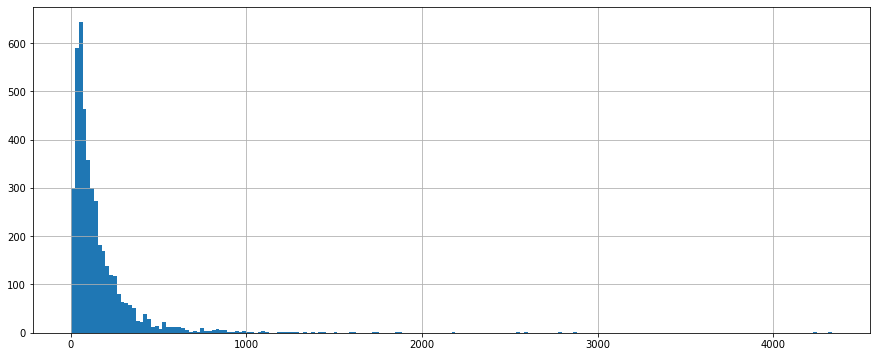

In [ ]:
seq_len = [len(i.split()) for i in X_train]
plt.figure(figsize=(15,6))
pd.Series(seq_len).hist(bins=200)

In [ ]:
pd.Series(seq_len).describe()

count    4296.000000
mean      156.653631
std       213.775985
min         1.000000
25%        51.000000
50%        97.000000
75%       188.000000
max      4336.000000
dtype: float64

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length=200,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_valid.tolist(),
    max_length=200,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length=200,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
y_train = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
y_valid = torch.tensor(y_valid.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
y_test = torch.tensor(y_test.tolist())

In [ ]:
target = y_train.detach().cpu().numpy()
class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
# target = torch.from_numpy(target).long()

In [ ]:
batch_size = 32

train_dataset = TensorDataset(train_seq, train_mask, y_train)
train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size)

valid_dataset = TensorDataset(val_seq, val_mask, y_valid)
val_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_seq, test_mask, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, hidden_state = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = BERT_Arch(bert).to(device)

In [ ]:
from torchsummary import summary

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(target), target)
print("Class Weights:", class_weights)

Class Weights: [0.65688073 2.09356725]


In [ ]:
weights = torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)
loss_fn = nn.NLLLoss(weight=weights) 
epochs = 15

In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]
  
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]  # collate_fn task
        sent_id, mask, labels = batch

        model.zero_grad()        
        preds = model(sent_id, mask)
        loss = loss_fn(preds, labels)

        total_loss = total_loss + loss.item()
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
    scheduler.step()
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [ ]:
import time

def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    for step,batch in enumerate(valid_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_dataloader)))
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
        loss = loss_fn(preds,labels)
        total_loss = total_loss + loss.item()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(valid_dataloader) 
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')
train_losses, valid_losses = [], []
root_model = ''
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/data/email_spam/saved_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.356
Validation Loss: 0.327

 Epoch 2 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.251
Validation Loss: 0.249

 Epoch 3 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.206
Validation Loss: 0.156

 Epoch 4 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.223
Validation Loss: 0.150

 Epoch 5 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.212
Validation Loss: 0.240

 Epoch 6 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.160
Validation Loss: 0.189

 Epoch 7 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.173
Validation Loss: 0.171

 Epoch 8 / 15
  Batch    50  of    135.
  Batch   100  of    135.

Evaluating...

Training Loss: 0.151
Validat

In [ ]:
path = '/content/drive/My Drive/data/email_spam/saved_weights.pt'
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))  # as GPU is out of memory
with torch.no_grad():
    train_preds = model(train_seq.to(device), train_mask.to(device))
    train_preds = train_preds.detach().cpu().numpy()

    test_preds = model(test_seq.to(device), test_mask.to(device))
    test_preds = test_preds.detach().cpu().numpy()
train_preds = np.argmax(train_preds, axis = 1)
test_preds = np.argmax(test_preds, axis = 1)

In [ ]:
report(y_train, train_preds, y_test, test_preds)